In [1]:
!pip install numpyro

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

from patsy import dmatrices

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive

from plotnine import *

numpyro.set_host_device_count(4)
rng_key = random.PRNGKey(0)

In [3]:
def summary_pars(samples, pars = None):
  if not (pars):
    pars = samples.keys()
  print_summary({k: samples[k] for k in pars})
  return None

All three problems below are based on the same data. The data in data(foxes) are 116 foxes from 30 different urban groups in England. These foxes are like street gangs. Group size varies from 2 to 8 individuals. Each group maintains its own (almost exclusive) urban territory. Some territories are larger than others. The area variable encodes this information. Some territories also have more avgfood than others. We want to model the weight of each fox. For the problems below, assume this DAG:
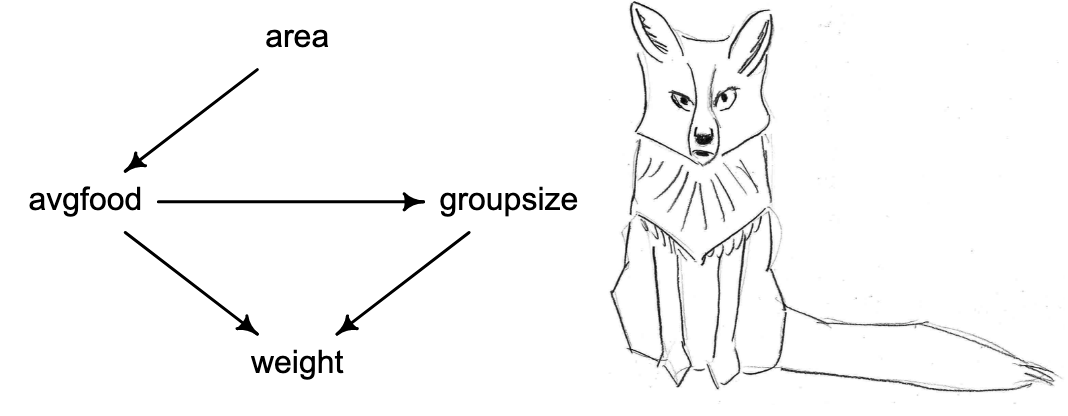

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/foxes.csv', delimiter=';')
df['log_weight'] = jnp.log(df.weight.values)
df.head()

,group,avgfood,groupsize,area,weight,log_weight
0,1,0.37,2,1.09,5.02,1.613430
1,1,0.37,2,1.09,2.84,1.043804
2,2,0.53,2,2.05,5.33,1.673351
3,2,0.53,2,2.05,6.07,1.803359
4,3,0.49,2,2.12,5.85,1.766442


In [5]:
df.log_weight.values.std()

0.2750813

## Problem 1

Use a model to infer the total causal influence of area on weight. Would increasing the area available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the possible outcome range.

In [6]:
def m1(area, weight = None):
  b_area = numpyro.sample('b_area', dist.Normal(0, 1))
  intercept = numpyro.sample('intercept', dist.Normal(1.5, 5))

  sigma = numpyro.sample('sigma', dist.HalfCauchy(1))

  mu = numpyro.deterministic('mu', intercept + b_area * area)
  y = numpyro.sample('y', dist.Normal(mu, sigma), obs = weight)

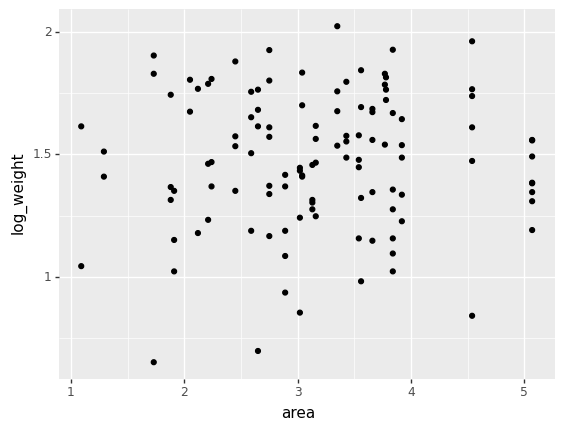

<ggplot: (8739928964553)>

In [7]:
(
    ggplot(df) +
    geom_point(aes(x='area', y='log_weight'))
)

In [8]:
areas = jnp.linspace(1, 6, num = 100)

In [9]:
rng_key, rng_key_ = random.split(rng_key)

m1_prior_predictive = Predictive(m1, num_samples=20)
m1_prior_pred = m1_prior_predictive(rng_key_, area = areas)['mu']

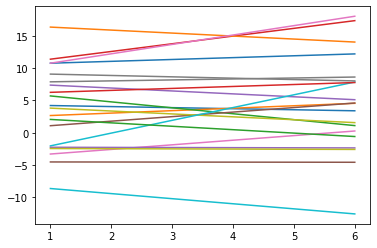

In [10]:
for i in jnp.arange(m1_prior_pred.shape[0]):
  plt.plot(areas, m1_prior_pred[i,:])

In [11]:
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(m1)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_chains=4,
            num_samples=num_samples, progress_bar=True)
mcmc.run(rng_key_, area = df.area.values, weight = df.log_weight.values)
mcmc.print_summary()
m1_samples = mcmc.get_samples()






                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     b_area      0.01      0.03      0.01     -0.04      0.06   2382.50      1.00
  intercept      1.44      0.09      1.44      1.29      1.60   2347.27      1.00
      sigma      0.28      0.02      0.28      0.25      0.31   3328.60      1.00

Number of divergences: 0


There seems to be very little association between `log(weight)` and `area`

## Problem 2
Now infer the causal impact of adding food (avgfood) to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

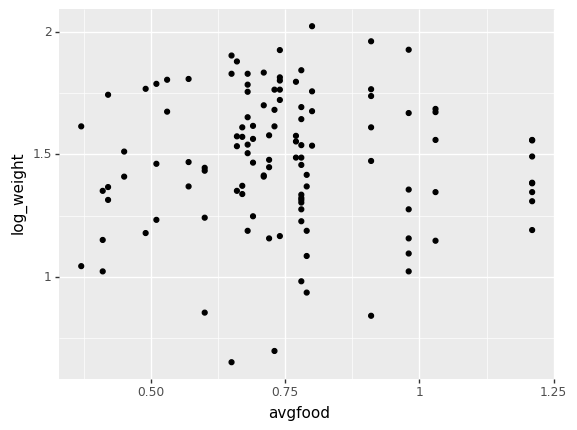

<ggplot: (8739927172869)>

In [12]:
(
    ggplot(df) +
    geom_point(aes(x='avgfood', y='log_weight'))
)

In [13]:
def m2(food, weight = None):
  b_food = numpyro.sample('b_food', dist.Normal(0, 1))
  intercept = numpyro.sample('intercept', dist.Normal(1.5, 5))

  sigma = numpyro.sample('sigma', dist.HalfCauchy(1))

  mu = numpyro.deterministic('mu', intercept + b_food * food)
  y = numpyro.sample('y', dist.Normal(mu, sigma), obs = weight)

In [14]:
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(m2)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_chains=4,
            num_samples=num_samples, progress_bar=True)
mcmc.run(rng_key_, food = df.avgfood.values, weight = df.log_weight.values)
mcmc.print_summary()
m2_samples = mcmc.get_samples()






                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     b_food     -0.02      0.13     -0.02     -0.24      0.18   2810.78      1.00
  intercept      1.49      0.10      1.49      1.33      1.66   2817.85      1.00
      sigma      0.28      0.02      0.28      0.25      0.31   3725.33      1.00

Number of divergences: 0


Again, the association is very small

## Problem 3
Now infer the causal impact of group size. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they make sense together?

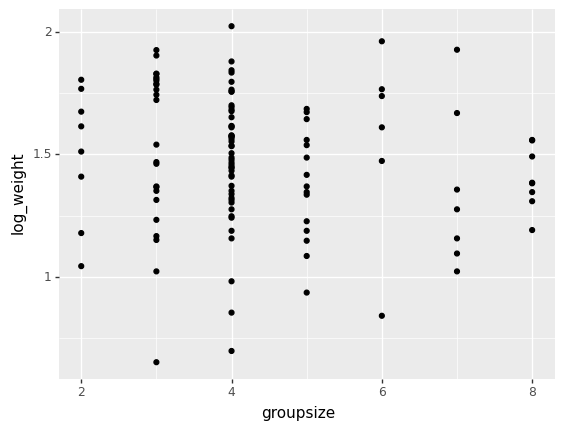

<ggplot: (8739926155245)>

In [15]:
(
    ggplot(df) +
    geom_point(aes(x='groupsize', y='log_weight'))
)

In [16]:
def m3(food, groupsize, weight = None):
  b_food = numpyro.sample('b_food', dist.Normal(0, 1))
  b_groupsize = numpyro.sample('b_groupsize', dist.Normal(0, 1))
  intercept = numpyro.sample('intercept', dist.Normal(1.5, 5))

  sigma = numpyro.sample('sigma', dist.HalfCauchy(1))

  mu = numpyro.deterministic('mu', intercept + b_food * food + b_groupsize * groupsize)
  y = numpyro.sample('y', dist.Normal(mu, sigma), obs = weight)

In [17]:
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(m3)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_chains=4,
            num_samples=num_samples, progress_bar=True)
mcmc.run(rng_key_,
         food = df.avgfood.values,
         groupsize = df.groupsize.values,
         weight = df.log_weight.values)
mcmc.print_summary()
m3_samples = mcmc.get_samples()






                   mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_food      0.78      0.29      0.77      0.33      1.27   2104.07      1.00
  b_groupsize     -0.12      0.04     -0.12     -0.18     -0.06   2503.65      1.00
    intercept      1.40      0.10      1.40      1.23      1.57   2883.79      1.00
        sigma      0.27      0.02      0.27      0.24      0.30   3893.51      1.00

Number of divergences: 0


Because `avgfood` confounds the relationships between , I included it in the regression. While `avgfood` was not significant on its own, it was significant when `groupsize` was included (`groupsize` partially mediates the effect of `avgfood` on `weight`).